In [19]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

torch.set_default_dtype(torch.float32)

import pickle, yaml
from pathlib import Path

from flumen import CausalFlowModel, print_gpu_info, TrajectoryDataset, TrunkNet
from flumen.train import EarlyStopping, train_step, validate

from flumen.utils import trajectory,plot_space_time_flat_trajectory, plot_space_time_flat_trajectory_V2
from argparse import ArgumentParser
import time
import matplotlib.pyplot as plt

import wandb
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import deepxde as dde

from deepxde.nn.pytorch.fnn import FNN
from deepxde.nn.pytorch.nn import NN
from deepxde.nn import activations
from deepxde.utils.external import plot_best_state,plot_loss_history
import os
os.chdir("C:/Users/20192139/Documents/5ARG45 - Thesis/Code/FlowFunction/flumen")  # Change this to your actual path

def get_data(data):
    nx = 100
    nt = 101
    x = data["x"].astype(np.float32)
    t = data["t"].astype(np.float32)
    u = data["u"].astype(np.float32)  # N x nt x nx
    f = data["forcing"].astype(np.float32)  # N x nx
    u0 = u[:, 0, :]  # N x nx
    u0_and_f = np.concatenate([u0, f], axis=1)  # shape N, nx2
    
    xt = np.vstack((np.ravel(x), np.ravel(t))).T
    u = u.reshape(-1, nt * nx)
    return (u0_and_f, xt), u


class PODDeepONet(NN):
    """Deep operator network with proper orthogonal decomposition (POD) for dataset in
    the format of Cartesian product.

    Args:
        pod_basis: POD basis used in the trunk net.
        layer_sizes_branch: A list of integers as the width of a fully connected network,
            or `(dim, f)` where `dim` is the input dimension and `f` is a network
            function. The width of the last layer in the branch and trunk net should be
            equal.
        activation: If `activation` is a ``string``, then the same activation is used in
            both trunk and branch nets. If `activation` is a ``dict``, then the trunk
            net uses the activation `activation["trunk"]`, and the branch net uses
            `activation["branch"]`.
        layer_sizes_trunk (list): A list of integers as the width of a fully connected
            network. If ``None``, then only use POD basis as the trunk net.

    References:
        `L. Lu, X. Meng, S. Cai, Z. Mao, S. Goswami, Z. Zhang, & G. E. Karniadakis. A
        comprehensive and fair comparison of two neural operators (with practical
        extensions) based on FAIR data. arXiv preprint arXiv:2111.05512, 2021
        <https://arxiv.org/abs/2111.05512>`_.
    """

    def __init__(
        self,
        pod_basis,
        layer_sizes_branch,
        activation,
        kernel_initializer,
        layer_sizes_trunk=None,
        regularization=None,
    ):
        super().__init__()
        self.regularizer = regularization
        self.pod_basis = torch.as_tensor(pod_basis, dtype=torch.float32)
        if isinstance(activation, dict):
            activation_branch = activation["branch"]
            self.activation_trunk = activations.get(activation["trunk"])
        else:
            activation_branch = self.activation_trunk = activations.get(activation)

        if callable(layer_sizes_branch[1]):
            # User-defined network
            self.branch = layer_sizes_branch[1]
        else:
            # Fully connected network
            self.branch = FNN(layer_sizes_branch, activation_branch, kernel_initializer)

        self.trunk = None
        if layer_sizes_trunk is not None:
            self.trunk = FNN(
                layer_sizes_trunk, self.activation_trunk, kernel_initializer
            )
            self.b = torch.nn.parameter.Parameter(torch.tensor(0.0))

        print("POD basis shape:", self.pod_basis.shape)

    def forward(self, inputs):
        x_func = inputs[0]
        x_loc = inputs[1]
        # Branch net to encode the input function
        x_func = self.branch(x_func)
        # Trunk net to encode the domain of the output function
        if self.trunk is None:
            # POD only
            x = torch.einsum("bi,ni->bn", x_func, self.pod_basis)
        else:
            x_loc = self.activation_trunk(self.trunk(x_loc))
            x = torch.einsum(
                "bi,ni->bn", x_func, torch.concat((self.pod_basis, x_loc), 1)
            )
            x += self.b

        if self._output_transform is not None:
            x = self._output_transform(inputs, x)
        return x



Load in data

In [5]:
# sys_args = ap.parse_args()
# data_don = "data/Brian2/DeepONet/brian2_gaussian_DeepONet_T2500.pkl"
data_don = "data/Brian2/DeepONet/brian2_gaussian_DeepONet_T500_Time10.pkl"
# data_flow = "data/Brian2/Transfer_Learning/brian2_mexhat_T2500.pkl"
data_path = Path(data_don)
with data_path.open('rb') as f:
    data = pickle.load(f)
loc = data['Locations'] * 100 # scale

In [9]:
def process_example(start_idx, end_idx, t, u, delta):
    init_time = 0.

    u_start_idx = int(np.floor((t[start_idx] - init_time) / delta))
    u_end_idx = int(np.floor((t[end_idx] - init_time) / delta))
    u_sz = 1 + u_end_idx - u_start_idx
    u_seq = torch.zeros_like(u)
    u_seq[0:u_sz] = u[u_start_idx:(u_end_idx + 1)]

    deltas = torch.ones((u_seq.shape[0], 1))
    t_u_end = init_time + delta * u_end_idx
    t_u_start = init_time + delta * u_start_idx

    if u_sz > 1:
        deltas[0] = (1. - (t[start_idx] - t_u_start) / delta).item()
        deltas[u_sz - 1] = ((t[end_idx] - t_u_end) / delta).item()
    else:
        deltas[0] = ((t[end_idx] - t[start_idx]) / delta).item()

    deltas[u_sz:] = 0.

    rnn_input = torch.hstack((u_seq, deltas))
    return rnn_input, u_sz, t_u_end

def prepare_data(dataset,l,end):
    '''prepares data in DeepONet format'''
    init_state = []
    state = []
    seq_len_data = []
    rnn_input_data = []
    time_data = []
    time_u_data = []
    forcing_total = []
    u_total = []
    segment_length = 21
    # iterate over the batches in the dataset
    for j, batch in enumerate(dataset):
        x0, x0_n, t, y, y_n, u = batch # unpack values in batch
        print(len(t))
        print(y.shape)
        k = 5
        for i in range(0, y.shape[0]-segment_length+1, segment_length-1):
            print(i)
            chunk = y[i:i + segment_length]
            u_total.append(chunk)
            forcing_total.append(u[k])
            k += 10
    u_total = torch.stack(u_total) 
    forcing_total = torch.stack(forcing_total) 
    
    t = np.linspace(0.0,10,21) 
    t, x = np.meshgrid(t, l.numpy(), indexing='ij')
    
    data = {
    'x': x,
    't': t,
    'u': u_total.numpy(),
    'forcing': forcing_total.numpy()}
    return data

#     state = torch.stack(state)
#     init_state = torch.stack(init_state)
#     rnn_input_data = torch.stack(rnn_input_data)
#     time_data = torch.stack(time_data)
#     forcing_total = []
#     time_total = []
#     y_total = []
#     x0_total = []
#     j = 0
#     counter = 0
#     for i in range(1,len(init_state)):
#         if (i-20) % 100 == 0:
#             j = 0
#             counter = counter + 1
#         if i % 20 == 0:
#             if i == end:
#                 break
#             print(time_data[i-20+counter:i+counter])
#             forcing_deltas = rnn_input_data[i]
#             deltas = forcing_deltas[:,-1]
#             forcing = forcing_deltas[:, :-1]
#             forcing_total.append(forcing[j,:])
#             y_total.append(state[i-20+counter:i+counter])
#             time_total.append(time_data[i-20+counter:i+counter])
#             x0_total.append(init_state[i])
#             j += 10
            
#     t = np.linspace(0.5,10,20) 
#     t, x = np.meshgrid(t, l.numpy(), indexing='ij')

#     data = {
#     'x': x,
#     'x0':torch.stack(x0_total).numpy(),
#     't': t,
#     'u': torch.stack(y_total).numpy(),
#     'forcing': torch.stack(forcing_total).numpy()}
#     return data

data_train = prepare_data(data['train'],loc,end=None) # end is hardcoded, needed for some accumulating error
data_test = prepare_data(data['val'],loc,end=None) # end is hardcoded

101
torch.Size([101, 100])


IndexError: index 15 is out of bounds for dimension 0 with size 11

In [18]:
def prepare_data_10seconds(dataset,l,end):
    '''prepares data in DeepONet format'''
    init_state = []
    state = []
    seq_len_data = []
    rnn_input_data = []
    time_data = []
    time_u_data = []
    forcing_total = []
    u_total = []
    segment_length = 101
    # iterate over the batches in the dataset
    for j, batch in enumerate(dataset):
        x0, x0_n, t, y, y_n, u = batch # unpack values in batch
        forcing_total.append(u[5])
        u_total.append(y)

    u_total = torch.stack(u_total) 
    forcing_total = torch.stack(forcing_total) 
    
    t = np.linspace(0.0,10,101) 
    t, x = np.meshgrid(t, l.numpy(), indexing='ij')
    
    data = {
    'x': x,
    't': t,
    'u': u_total.numpy(),
    'forcing': forcing_total.numpy()}
    return data

data_train = prepare_data_10seconds(data['train'],loc,end=None) # end is hardcoded, needed for some accumulating error
data_test = prepare_data_10seconds(data['val'],loc,end=None) # end is hardcoded

In [20]:
x_train, y_train = get_data(data_train) 
x_test, y_test = get_data(data_test) 
# np.save("data/Brian2/DeepONet/x_train_gaussian.npy", x_train)
# np.save("data/Brian2/DeepONet/y_train_gaussian.npy", y_train)
# np.save("data/Brian2/DeepONet/x_test_gaussian.npy", x_test)
# np.save("data/Brian2/DeepONet/y_test_gaussian", y_test)
data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
nx = 100
input_dim_branch = 2 * nx
input_dim_trunk = 2
net = dde.nn.DeepONetCartesianProd(
    [input_dim_branch, 320, 320,320,320,320,320,320],
    [input_dim_trunk, 320, 320,320,320,320,320,320],
    "relu",
    "Glorot normal",
)

def mae_torch(y_true, y_pred):
    if not torch.is_tensor(y_true):
        y_true = torch.tensor(y_true)
    if not torch.is_tensor(y_pred):
        y_pred = torch.tensor(y_pred)
    return torch.mean(torch.abs(y_true - y_pred))

model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-3,
    decay=("inverse time", 1, 1e-4),
    metrics=[mae_torch],
)

Compiling model...
'compile' took 0.000663 s



In [21]:
callbacks = [
    dde.callbacks.EarlyStopping(monitor="loss_test", patience=100,start_from_epoch=100),
    dde.callbacks.ModelCheckpoint("models_DON/DeepONet/gaussian_T2500_deep_1208/model_l1.ckpt", save_better_only=True),
]

In [24]:
print('starting training')
losshistory, train_state = model.train(epochs=1, batch_size=None,display_every=10,model_save_path='models_DON/DeepONet/gaussian_T2500_deep_1208/L1',callbacks = callbacks)
print(losshistory)
print(train_state)


starting training
Training model...

Step      Train loss    Test loss     Test metric   
830       [8.91e-03]    [1.75e-02]    [7.14e-02]    
831       [9.19e-03]    [1.74e-02]    [7.26e-02]    

Best model at step 780:
  train loss: 8.64e-03
  test loss: 1.69e-02
  test metric: [6.91e-02]

Epoch 831: saving model to models_DON/DeepONet/gaussian_T2500_deep_1208/L1-831.pt ...

'train' took 1.250565 s



In [26]:
#model.restore("models_DON/DeepONet/-27100.pt", verbose=1)  # Replace ? with the exact filename
model.restore("models_DON/DeepONet/gaussian_T2500_deep_1208/L1-831.pt")

pred = model.predict(data.test_x)
print(pred.shape)
nt = 101
nx = 100
pred = pred.reshape(-1,nt, nx)
print(pred.shape)
out = data.test_y.reshape(-1,nt, nx)


(100, 10100)
(100, 101, 100)


In [97]:
branch_sample = np.ones(1, 200).astype(np.float32)
trunk_sample = np.ones(1, 2).astype(np.float32)

pred = model.predict((branch_sample, trunk_sample))
print(pred.shape)
print(pred)

(1, 1)
[[0.4675654]]


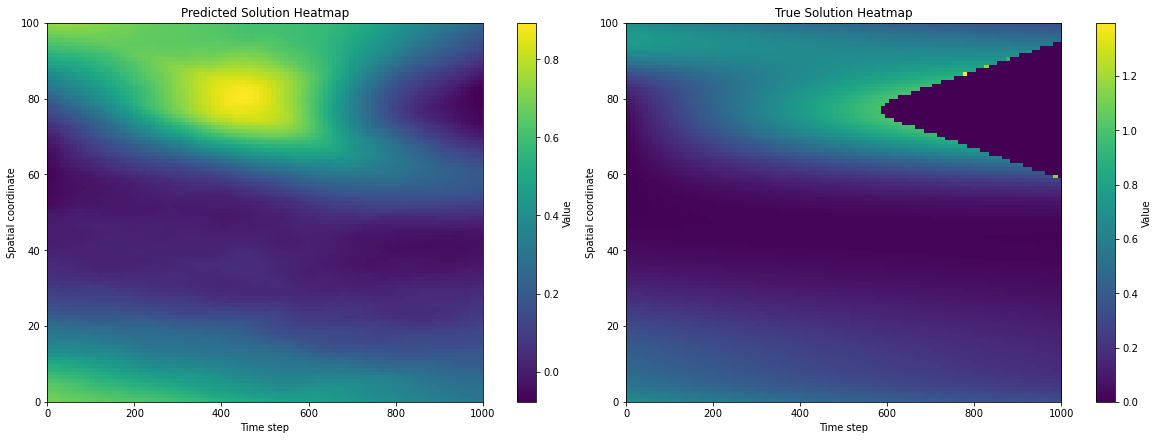

In [41]:
import matplotlib.pyplot as plt

traj = 3  # Choose trajectory index

fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot prediction
im0 = axes[0].imshow(pred[traj].T, aspect='auto', origin='lower', extent=[0, 1000, 0, 100])
axes[0].set_title("Predicted Solution Heatmap")
axes[0].set_xlabel("Time step")
axes[0].set_ylabel("Spatial coordinate")
fig.colorbar(im0, ax=axes[0], label="Value")

# Plot ground truth or output
im1 = axes[1].imshow(out[traj].T, aspect='auto', origin='lower', extent=[0, 1000, 0, 100])
axes[1].set_title("True Solution Heatmap")
axes[1].set_xlabel("Time step")
axes[1].set_ylabel("Spatial coordinate")
fig.colorbar(im1, ax=axes[1], label="Value")

plt.show()

In [51]:
# Example values
timesteps_to_plot = np.arange(1, 100, 100)
x = np.linspace(0, 90, pred.shape[1])  # replace with your actual x array if available
print(timesteps_to_plot.shape)
j = 101
for t in timesteps_to_plot:
    print(t)
    plt.figure(figsize=(8, 4))
    print(x.shape)
    plt.plot(out[traj][j], label="Ground Truth", linewidth=2)
    plt.plot(pred[traj][j], '--', label="Prediction", linewidth=2)
    plt.xlabel("Spatial coordinate")
    plt.ylabel("Solution value")
    plt.title(f"timestep {t}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

(1,)
1
(101,)


IndexError: index 101 is out of bounds for axis 0 with size 101

<Figure size 576x288 with 0 Axes>